by: Artyom Kurguzkin (kurg0002)


steps:

Explore the data

Prepare the data

Summurise the data
- are there any data clusters?

Make models and compare them

## Questions

- which prediction model, with which hyperparameters, works best for which label? why you think so?
- predict values for separate Predictions dataset

note, labels must be predicted independently (i.e., you cannot use the value from one label to help you predict the value for another label).

<br>

# Exploring and preparing Data
---

## Overview

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
# note, the location of the data file may very, so you have to change the path to fit your work setup
df = pd.read_csv('work/GameData.csv')
df.shape

(403, 386)

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)     # Show all rows (if needed)

df.head(5)

,GameName,String_java.lang.String,Off_int,End_int,int_int,Undefined_int,Piece_game.equipment.component.Piece,Board_game.equipment.container.board.Board,MancalaBoard_game.equipment.container.board.custom.MancalaBoard,Track_game.equipment.container.board.Track,Dice_game.equipment.container.other.Dice,Hand_game.equipment.container.other.Hand,Equipment_game.equipment.Equipment,Map_game.equipment.other.Map,Regions_game.equipment.other.Regions,All_game.functions.booleans.all.All,Can_game.functions.booleans.can.Can,Is_game.functions.booleans.is.Is,And_game.functions.booleans.math.And,Equals_game.functions.booleans.math.Equals,Ge_game.functions.booleans.math.Ge,Gt_game.functions.booleans.math.Gt,If_game.functions.booleans.math.If,Le_game.functions.booleans.math.Le,Lt_game.functions.booleans.math.Lt,Not_game.functions.booleans.math.Not,NotEqual_game.functions.booleans.math.NotEqual,Or_game.functions.booleans.math.Or,No_game.functions.booleans.no.No,Was_game.functions.booleans.was.Was,Mul_game.functions.dim.math.Mul,Difference_game.functions.directions.Difference,Directions_game.functions.directions.Directions,If_game.functions.directions.If,Div_game.functions.floats.math.Div,Mul_game.functions.floats.math.Mul,Sub_game.functions.floats.math.Sub,Square_game.functions.graph.generators.basis.square.Square,Tri_game.functions.graph.generators.basis.tri.Tri,Concentric_game.functions.graph.generators.shape.concentric.Concentric,Rectangle_game.functions.graph.generators.shape.Rectangle,Regular_game.functions.graph.generators.shape.Regular,Repeat_game.functions.graph.generators.shape.Repeat,Spiral_game.functions.graph.generators.shape.Spiral,Wedge_game.functions.graph.generators.shape.Wedge,Add_game.functions.graph.operators.Add,Hole_game.functions.graph.operators.Hole,MakeFaces_game.functions.graph.operators.MakeFaces,Merge_game.functions.graph.operators.Merge,Remove_game.functions.graph.operators.Remove,Rotate_game.functions.graph.operators.Rotate,Scale_game.functions.graph.operators.Scale,Shift_game.functions.graph.operators.Shift,SplitCrossings_game.functions.graph.operators.SplitCrossings,Array_game.functions.intArray.array.Array,Results_game.functions.intArray.math.Results,Union_game.functions.intArray.math.Union,Values_game.functions.intArray.values.Values,Ahead_game.functions.ints.board.Ahead,CentrePoint_game.functions.ints.board.CentrePoint,Column_game.functions.ints.board.Column,Coord_game.functions.ints.board.Coord,HandSite_game.functions.ints.board.HandSite,Id_game.functions.ints.board.Id,MapEntry_game.functions.ints.board.MapEntry,RegionSite_game.functions.ints.board.RegionSite,Row_game.functions.ints.board.Row,Where_game.functions.ints.board.where.Where,Count_game.functions.ints.count.Count,Face_game.functions.ints.dice.Face,Between_game.functions.ints.iterator.Between,From_game.functions.ints.iterator.From,Level_game.functions.ints.iterator.Level,Pips_game.functions.ints.iterator.Pips,Player_game.functions.ints.iterator.Player,Site_game.functions.ints.iterator.Site,To_game.functions.ints.iterator.To,Last_game.functions.ints.last.Last,Add_game.functions.ints.math.Add,Div_game.functions.ints.math.Div,If_game.functions.ints.math.If,Max_game.functions.ints.math.Max,Min_game.functions.ints.math.Min,Mod_game.functions.ints.math.Mod,Mul_game.functions.ints.math.Mul,Sub_game.functions.ints.math.Sub,Size_game.functions.ints.size.Size,TopLevel_game.functions.ints.stacking.TopLevel,Amount_game.functions.ints.state.Amount,Counter_game.functions.ints.state.Counter,Mover_game.functions.ints.state.Mover,Next_game.functions.ints.state.Next,Pot_game.functions.ints.state.Pot,Score_game.functions.ints.state.Score,State_game.functions.ints.state.State,Var_game.functions.ints.state.Var,What_game.functions.ints.state.What,Who_game.functions.ints.state.Who,TrackSite_game.functions.ints.trackSite.TrackSite,Value_game.functions.ints.value.Value,Exact_game.functions.range.math.Exact,Max_game.functions.range.math.Max,Min_game.functions.range.math.Min,Range_

* last 5 collumns: labels to be predicted. Collumns [0-381] - ludemes - game properties. Lots of them seems like binary values.

<br>

In [20]:

binary_cols = []
categorical_cols = []
continuous_cols = []

min_categories_col = None
min_categories_count = float('inf')

min_range_col = None
min_range_value = float('inf')

for col in df.columns:
    # Ignore NA values
    col_data = df[col].dropna()

    # Skip empty columns
    if col_data.empty:
        continue

    # Check for binary (0 or 1)
    if col_data.isin([0, 1]).all():
        binary_cols.append(col)
    # Check for categorical (strings or small unique values)
    elif col_data.dtype == 'object' or (col_data.nunique() < 10 and not np.issubdtype(col_data.dtype, np.number)):
        categorical_cols.append(col)
        # Track column with minimal number of unique categories
        if col_data.nunique() < min_categories_count:
            min_categories_count = col_data.nunique()
            min_categories_col = col
    # Otherwise, it's continuous data
    else:
        continuous_cols.append(col)
        # Track column with minimal range of values (max - min)
        col_range = col_data.max() - col_data.min()
        if col_range < min_range_value:
            min_range_value = col_range
            min_range_col = col


# Count the number of columns for each type
counts = {
    'Binary': len(binary_cols),
    'Categorical': len(categorical_cols),
    'Continuous': len(continuous_cols)
}

# Print columns with minimal categories and minimal range
if min_categories_col:
    print(f"Column with the fewest unique categories (categorical): {min_categories_col} ({min_categories_count} categories)")

if min_range_col:
    unique_values = df[min_range_col].dropna().unique()
    print(f"Column with the smallest range (continuous): {min_range_col}")
    print(f"Unique values in {min_range_col}: {unique_values}")


print("\nCounts of each data type:")
print(counts)


Column with the fewest unique categories (categorical): Category (6 categories)
Column with the smallest range (continuous): End_game.rules.end.End
Unique values in End_game.rules.end.End: [1 2]

Counts of each data type:
{'Binary': 66, 'Categorical': 4, 'Continuous': 316}


We need to ascertain that there are any actual continuous data, not descrete ones.

In [21]:
continuous_columns = []

for col in df.columns:
    # Ignore NA values
    col_data = df[col].dropna()

    # Skip if column is empty
    if col_data.empty:
        continue

    # Attempt to convert to numeric, forcing non-numeric values to NaN
    numeric_data = pd.to_numeric(col_data, errors='coerce')

    # Check if any value is non-integer (continuous)
    if numeric_data.notna().any() and (numeric_data.apply(lambda x: not float(x).is_integer())).any():
        continuous_columns.append(col)
        unique_values = numeric_data.unique()
        print(f"Column with continuous values: {col}")

if not continuous_columns:
    print("No columns with continuous values found.")

Column with continuous values: UCT


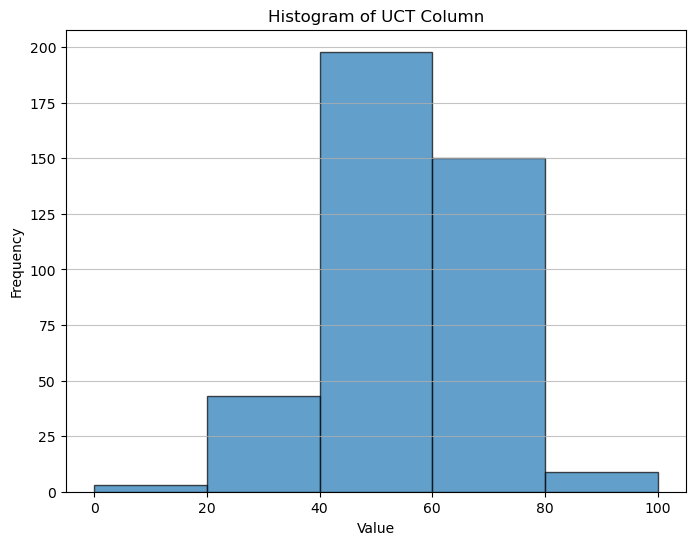

In [22]:
uct_data = df['UCT'].dropna()

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(uct_data, bins=5, edgecolor='black', alpha=0.7)
plt.title('Histogram of UCT Column')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The only collumn that is continuous is UCT. Now we need to deal with potential NA values.

In [25]:
for col in df.columns:
    # Count NA values
    na_count = df[col].isna().sum()
    total_count = df[col].shape[0]
    na_percentage = (na_count / total_count) * 100

    if na_percentage > 40:
        # Drop the column if NA percentage is more than 40%
        df.drop(col, axis=1, inplace=True)
        print(f"Dropped column: {col} (NA percentage: {na_percentage:.2f}%)")
    elif na_count > 0:  # Check if there are any NA values to substitute
        # Substitute NA with the most popular value (mode)
        most_common_value = df[col].mode()[0] if not df[col].mode().empty else np.nan
        substituted_count = df[col].isna().sum()  # Count before substitution
        
        # Fill NA and assign back to the column to avoid warning
        df[col] = df[col].fillna(most_common_value)
        
        substituted_count -= df[col].isna().sum()  # Count after substitution
        print(f"Column: {col}, substituted {substituted_count} NA(s) with: {most_common_value}")

Dropped column: int_int (NA percentage: 96.53%)
Column: Board_game.equipment.container.board.Board, substituted 1 NA(s) with: 1.0
Column: Equipment_game.equipment.Equipment, substituted 1 NA(s) with: 1.0
Column: To_game.functions.ints.iterator.To, substituted 3 NA(s) with: 1.0


/tmp/ipykernel_334/2286076241.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(most_common_value, inplace=True)


## Empty and zero values

### Collumns

In [82]:
# Count the number of NaN values in each column
na_counts = df.isna().sum()

# Filter to get only columns with NaN values
na_columns = na_counts[na_counts > 0]

# Convert to DataFrame for better visualization
na_counts_df = na_columns.reset_index()
na_counts_df.columns = ['Column Name', 'Number of NaN Values']

# Display the DataFrame
na_counts_df

,Column Name,Number of NaN Values
0,int_int,389
1,Board_game.equipment.container.board.Board,1
2,Equipment_game.equipment.Equipment,1
3,To_game.functions.ints.iterator.To,3


the `int_int` collumn is almost entirely empty. Based on the table, there are also a lot of 0 values, which could also be interpreted as empty cells.

<br>

In [83]:
df.drop(columns=['int_int'], inplace=True)

In [84]:
# Check if any columns are all zeros and print the result
print(((df.isna() | (df == 0)).all()).any())


False


All of the collumns have at least on not-0 / not-NA entry 

<br>

In [85]:
zero_values = (df == 0).sum()
threshold = 376 
zero_columns = zero_values[zero_values > threshold]
print(len(zero_columns))

220


out of 381 features, there are 220 which have at least 376 (out of 403) `0` values in them. Which means majority of the games are described using the small subset of available ludemes.

In [97]:
def has_min_distinct_values(column, min_values=4):
    return column.nunique(dropna=True) >= min_values

# Select columns that have at least 5 distinct values
non_binary_columns = df.columns[df.apply(has_min_distinct_values)]

# Create a new DataFrame with only the selected columns
non_binary_df = df[non_binary_columns]

# Display the shape of the new DataFrame
non_binary_df.shape

(403, 234)

In [98]:
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df' is your original DataFrame

# Step 1: Remove the first column and the last five columns
df_reduced = non_binary_df.iloc[:, 1:-5]

# Step 2: Apply Min-Max scaling to the remaining columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_reduced)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=df_reduced.columns)

# Step 3: Find the top 10 features with the highest variance
top_variance_features = scaled_df.var().nlargest(10)

# Display the top 10 features and their variances
top_variance_features

Prev_game.functions.booleans.is.IsPlayerType          0.058160
Moves_game.functions.booleans.no.NoMoveType           0.037010
Win_game.types.play.ResultType                        0.036607
Phase_game.rules.phase.Phase                          0.033980
Map_game.equipment.other.Map                          0.032635
Track_game.functions.region.sites.SitesTrackType      0.030001
No_game.functions.booleans.no.No                      0.029574
Hop_game.rules.play.moves.nonDecision.effect.Hop      0.028004
Set_game.rules.start.set.Set                          0.027915
Roll_game.rules.play.moves.nonDecision.effect.Roll    0.026180
dtype: float64

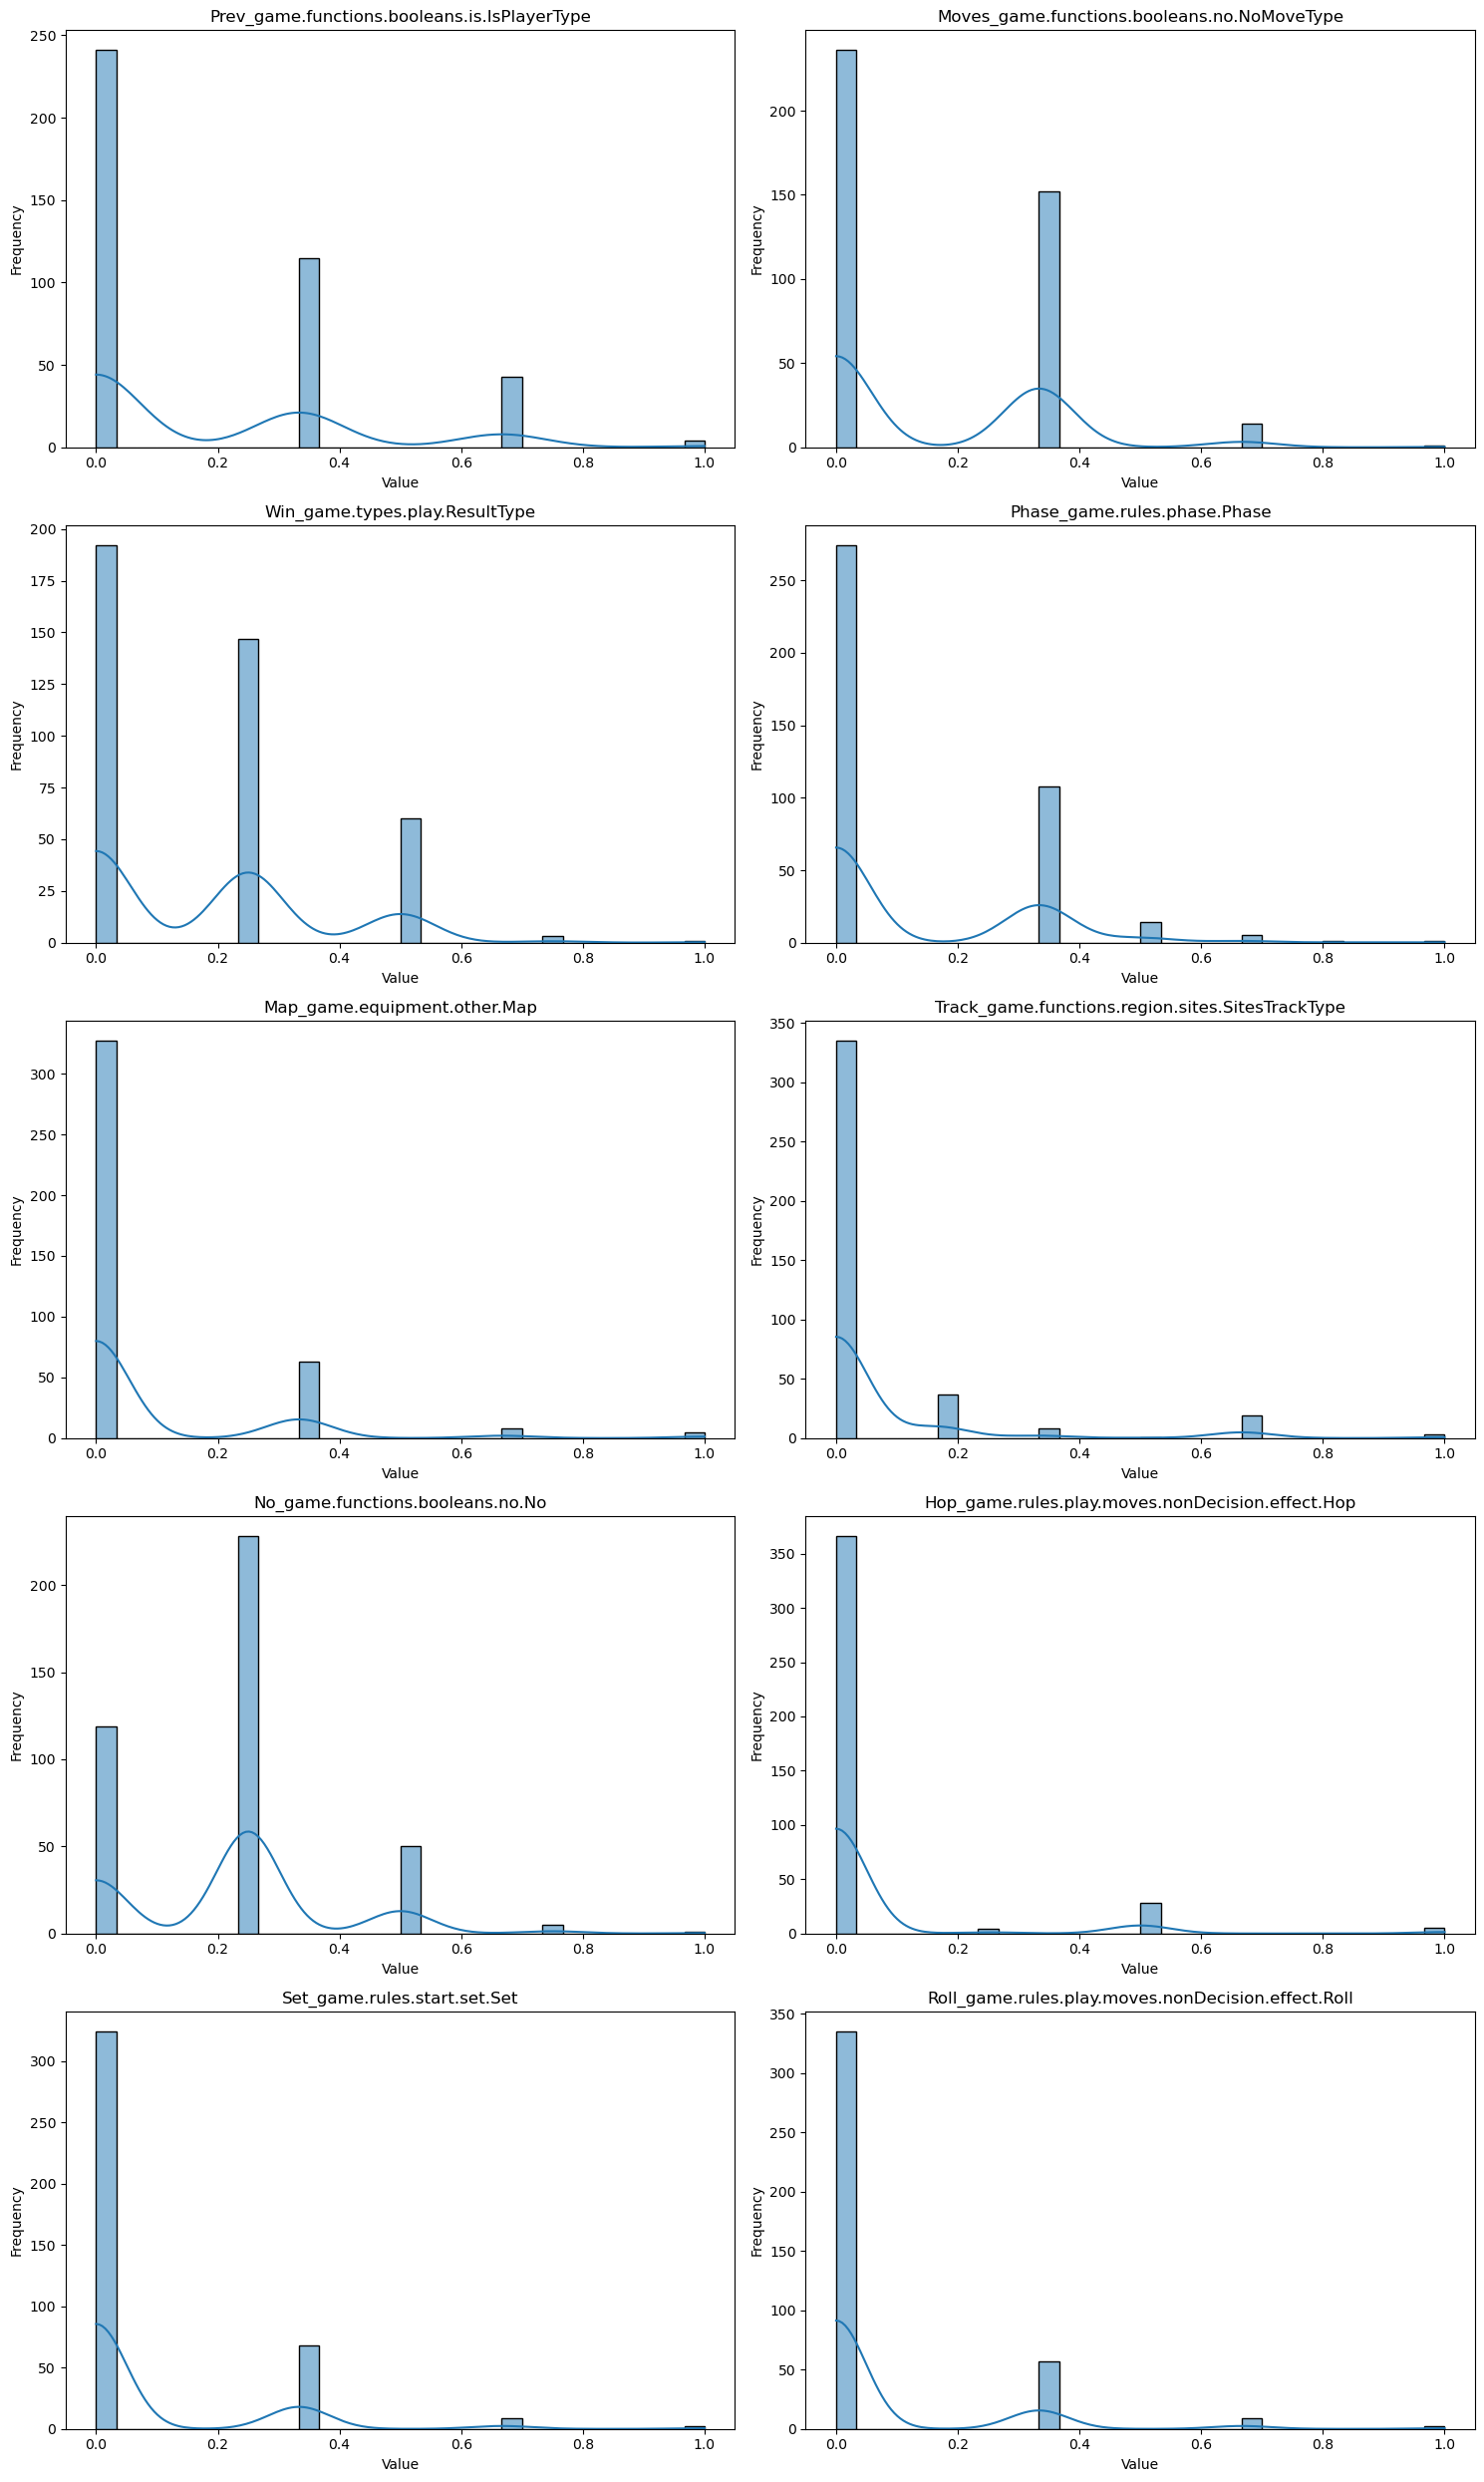

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'top_variance_features' contains the top 10 features
top_features = top_variance_features.index

# Set up the matplotlib figure
plt.figure(figsize=(15, 25))

# Create a grid of histograms for the top 10 features with 2 columns
for i, feature in enumerate(top_features):
    plt.subplot(5, 2, i + 1)  # 5 rows and 2 columns
    sns.histplot(scaled_df[feature], bins=30, kde=True)
    plt.title(feature)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust the layout
plt.show()

`No_game.functions.booleans.no.No` is the only feature that tends to normal distribution 


<br>

---

It doesn't make sense to analyse empty and 0 rows, since significant number of collumns are empty. we remove them first.

In [41]:
zero_values = (df == 0).sum() 
zero_columns = zero_values[zero_values > 350].index

missing_values = df.isna().sum()
empty_columns = missing_values[missing_values > 100].index

columns_to_drop = set(zero_columns).union(set(empty_columns))

new_df = df.drop(columns=columns_to_drop)

new_df.shape

(403, 129)

In [61]:
new_df.describe()

,String_java.lang.String,Off_int,Piece_game.equipment.component.Piece,Board_game.equipment.container.board.Board,MancalaBoard_game.equipment.container.board.custom.MancalaBoard,Track_game.equipment.container.board.Track,Dice_game.equipment.container.other.Dice,Hand_game.equipment.container.other.Hand,Equipment_game.equipment.Equipment,Map_game.equipment.other.Map,Regions_game.equipment.other.Regions,All_game.functions.booleans.all.All,Can_game.functions.booleans.can.Can,Is_game.functions.booleans.is.Is,And_game.functions.booleans.math.And,Equals_game.functions.booleans.math.Equals,Gt_game.functions.booleans.math.Gt,Lt_game.functions.booleans.math.Lt,Not_game.functions.booleans.math.Not,NotEqual_game.functions.booleans.math.NotEqual,Or_game.functions.booleans.math.Or,No_game.functions.booleans.no.No,Directions_game.functions.directions.Directions,Square_game.functions.graph.generators.basis.square.Square,Rectangle_game.functions.graph.generators.shape.Rectangle,Merge_game.functions.graph.operators.Merge,Shift_game.functions.graph.operators.Shift,HandSite_game.functions.ints.board.HandSite,Id_game.functions.ints.board.Id,MapEntry_game.functions.ints.board.MapEntry,Count_game.functions.ints.count.Count,Between_game.functions.ints.iterator.Between,From_game.functions.ints.iterator.From,Site_game.functions.ints.iterator.Site,To_game.functions.ints.iterator.To,Last_game.functions.ints.last.Last,Add_game.functions.ints.math.Add,If_game.functions.ints.math.If,Sub_game.functions.ints.math.Sub,Mover_game.functions.ints.state.Mover,Who_game.functions.ints.state.Who,TrackSite_game.functions.ints.trackSite.TrackSite,Difference_game.functions.region.math.Difference,Expand_game.functions.region.math.Expand,Union_game.functions.region.math.Union,Sites_game.functions.region.sites.Sites,Game_game.Game,Players_game.players.Players,ByScore_game.rules.end.ByScore,End_game.rules.end.End,If_game.rules.end.If,Result_game.rules.end.Result,NextPhase_game.rules.phase.NextPhase,Phase_game.rules.phase.Phase,Move_game.rules.play.moves.decision.Move,Apply_game.rules.play.moves.nonDecision.effect.Apply,FromTo_game.rules.play.moves.nonDecision.effect.FromTo,Remove_game.rules.play.moves.nonDecision.effect.Remove,Do_game.rules.play.moves.nonDecision.effect.requirement.Do,Roll_game.rules.play.moves.nonDecision.effect.Roll,Set_game.rules.play.moves.nonDecision.effect.set.Set,Sow_game.rules.play.moves.nonDecision.effect.Sow,MoveAgain_game.rules.play.moves.nonDecision.effect.state.MoveAgain,Then_game.rules.play.moves.nonDecision.effect.Then,ForEach_game.rules.play.moves.nonDecision.operators.foreach.ForEach,And_game.rules.play.moves.nonDecision.operators.logical.And,If_game.rules.play.moves.nonDecision.operators.logical.If,Or_game.rules.play.moves.nonDecision.operators.logical.Or,Play_game.rules.play.Play,Rules_game.rules.Rules,Place_game.rules.start.place.Place,Set_game.rules.start.set.Set,Start_game.rules.start.Start,Score_game.util.end.Score,Pair_game.util.math.Pair,Between_game.util.moves.Between,From_game.util.moves.From,Piece_game.util.moves.Piece,To_game.util.moves.To,Sites_game.functions.booleans.all.AllSitesType,Move_game.functions.booleans.can.CanType,In_game.functions.booleans.is.IsInType,Line_game.functions.booleans.is.IsLineType,Mover_game.functions.booleans.is.IsPlayerType,Prev_game.functions.booleans.is.IsPlayerType,Friend_game.functions.booleans.is.IsPlayerType,Enemy_game.functions.booleans.is.IsPlayerType,Empty_game.functions.booleans.is.IsSiteType,Moves_game.functions.booleans.no.NoMoveType,Pieces_game.functions.booleans.no.NoPieceType,Alternating_game.functions.graph.generators.basis.square.DiagonalsType,Pieces_game.functions.ints.count.CountComponentType,To_game.functions.ints.last.LastType,Move_game.functions.ints.trackSite.TrackSiteMoveType,Empty_game.functions.region.sites.SitesIndexType,Occupied_game.functions.region.sites.SitesOccupiedType,Hand_game.functions.region.sites.SitesPlayerType,Top_game.functions.region.sites.SitesSimpleType,Botto

### Rows

In [51]:
new_df.loc[(df.notna() & (df != 0)).sum(axis=1) >= 10].shape

(403, 129)

Each of the rows has at least 10 non zero and not NA entries. We assume that it is the minimum to describe a simple game.

In [47]:
nan_counts = df.isna().sum(axis=1)
zero_counts = (df == 0).sum(axis=1)
total_missing_or_zero = nan_counts + zero_counts

rows_with_missing_or_zero = df[total_missing_or_zero > 127]

print(len(rows_with_missing_or_zero))

403


none of the rows are completly empty

<br>

In [65]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_data = PCA().fit_transform(df)
plot = plt.scatter(X_data[:,0], X_data[:,1], c=df[-3])
plt.show()

ValueError: could not convert string to float: 'Senet'

<br>

# Modeling
--- 